In [117]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import numpy as np
import re
import json
import importlib

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

In [118]:
def print_title(title, line_length = 60, symbol = '-'):
    separator = symbol * ((line_length - len(title) - 2) // 2)
    print(f"{separator} {title} {separator}")

# EXPERIMENT DESIGN

## SOURCES INGESTION

-----------------------------------------------------------------------------------------

# EXPERIMENT RESULTS

## SOURCES INGESTION

### LOAD

In [ ]:
# Load raw data
file_name = 'ab_test_example_3.csv'
df_raw = pd.read_csv('../data/' + file_name)
display(df_raw.head(5))

# Make a copy
df = df_raw.copy()

# Check dtypes
print_title('INITIAL DATA TYPES')
print(df.dtypes)

### DTYPES

In [53]:
def format_columns(df, datetime_columns=[], int64_columns=[], float64_columns=[], str_columns=[]):
    for col in datetime_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    for col in int64_columns:
        if col in df.columns:
            df[col] = df[col].astype('Int64')  

    for col in float64_columns:
        if col in df.columns:
            df[col] = df[col].astype('float64')

    for col in str_columns:
        if col in df.columns:
            df[col] = df[col].astype('str')
    
    return df

In [ ]:
datetime_columns = ['WHEN_ENTERED_INTO_EXPERIMENT']
int64_columns = ['U_ID', 'PROMOTER_U_ID', 'IS_TREATMENT', 'COUNT_TRANSFERS', 'DAYS_TRANSACTING', 'DISTINCT_RECEIVERS']
float64_columns = ['TOTAL_TRANSFER_AMOUNT']
str_columns = ['VARIANT', 'USER_SEGMENT', 'PROMO_TAG']

# Basic data conversion
df = format_columns(df, datetime_columns, int64_columns, float64_columns, str_columns)

# Check dtypes
print_title('CONVERTED DATA TYPES')
print(df.dtypes)
display(df.head(5))

## DATA CLEANING

### CHECKS

In [ ]:
variant_column = 'VARIANT'

In [ ]:
# Quick checks on data
print_title('DF INFO')
display(df.info())

print_title('DF DESCRIBE')
display(df.describe())

# Check distribution of variants
print_title('VARIANT DISTRIBUTION')
display(df[variant_column].value_counts())

### DUPLICATES

In [ ]:
# Check for and drop duplicates in the entire DataFrame
duplicated_rows = df.duplicated().sum()
print('# of duplicated rows: ', duplicated_rows)

if duplicated_rows > 0:
    df = df.drop_duplicates()
    print('Duplicates in the DataFrame removed.')
else:
    print('No duplicates in the DataFrame found.')

In [ ]:
primary_key_column = 'U_ID'
timestamp_column = ''

# Check for duplicates in the unique columns
duplicated_rows = df[df[primary_key_column].duplicated(keep=False)]
print(f'# of duplicated on {primary_key_column} column: {duplicated_rows[primary_key_column].nunique()}')

if not duplicated_rows.empty:
    print(f'Duplicated {primary_key_column} and their rows:')
    display(duplicated_rows.sort_values(by = 'U_ID'))

    # Keep only the first following timestamp column order
    if timestamp_column == '':
        df = df.drop_duplicates(subset=primary_key_column, keep='last')
        print('Kept the most recent row for each duplicated U_ID.')
    else:
        df = df.sort_values(timestamp_column).drop_duplicates(subset=primary_key_column, keep='last')
        print('Kept the most recent row for each duplicated U_ID.')

### NULLS

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
print_title('NUMBER OF NULL VALUES')
print(missing_values)

In [92]:
# Fill null columns
df['TOTAL_TRANSFER_AMOUNT'] = df['TOTAL_TRANSFER_AMOUNT'].fillna(0)

### INCONSISTENCIES

In [ ]:
# Checks errors in variant labeling
checks = df[(df['IS_TREATMENT'] == 1) & (df['VARIANT'] != 'PRICE_PROMO')]
display(checks)
checks = df[(df['IS_TREATMENT'] == 0) & (df['VARIANT'] != 'CONTROL')]
display(checks)

## METRICS DEFINITION

In [105]:
# calculate the metrics, use metric_cnt_ or metric_cvr_
df['metric_cnt_total_transfer_amount'] = df['TOTAL_TRANSFER_AMOUNT']
df['metric_cvr_transaction'] = df['TOTAL_TRANSFER_AMOUNT'].apply(lambda x: 1 if x > 0 else 0, 1)

## DATA ANALYSIS

In [154]:
def remove_outliers(df, metric_column, factor=1.5):
    # Remove outliers using the IQR method and return filtered DataFrame rows
    q1 = df[metric_column].quantile(0.2)
    q3 = df[metric_column].quantile(0.8)
    iqr = q3 - q1
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr
    print("Low outlier limit:", lower_bound)
    print("Upper outlier limit:", upper_bound)
    initial_count = df.shape[0]
    df_filtered = df.loc[(df[metric_column] >= lower_bound) & (df[metric_column] <= upper_bound)]
    final_count = df_filtered.shape[0]
    print("Filtered", initial_count - final_count, "rows from ", initial_count, "to", final_count)
    return df_filtered

In [153]:
# Select metrics and columns involved in the test
primary_key_column = 'U_ID'
metric_column = 'metric_cnt_total_transfer_amount'
variant_column = 'VARIANT'
filter_outliers = True

selected_df = df[[primary_key_column, variant_column, metric_column]]

# Filter outliers:
if filter_outliers:
    selected_df = remove_outliers(selected_df, metric_column, 1)
display(selected_df.sample(5))

Low outlier limit: -5650.0
Upper outlier limit: 11300.0
Filtered 7183 rows from  45616 to 38433


,U_ID,VARIANT,metric_cnt_total_transfer_amount
34756,30643,CONTROL,0.0
3886,17417,PRICE_PROMO,9000.0
38969,36098,PRICE_PROMO,0.0
15775,32684,CONTROL,1000.0
28426,21210,CONTROL,0.0


### NUMBER OF VARIANTS

In [155]:
num_variants = selected_df[variant_column].nunique()

print(f"Number of Variants: {num_variants}")
print(f"Variants: {selected_df[variant_column].unique()}")

Number of Variants: 2
Variants: ['CONTROL' 'PRICE_PROMO']


### SAMPLE SIZES

In [157]:
# check if the sample size is large enough
# check if the variant sizes ar equal or not and the proportion

sample_sizes = selected_df[variant_column].value_counts()
print("Sample sizes per variant:")
print(sample_sizes)

variant_proportion = sample_sizes / sample_sizes.sum()
print("\nProportion per variant:")
print(variant_proportion)

variant_ratio = sample_sizes.max() / sample_sizes.min()
print(f"\nVariant Ratio (N = max/min): {variant_ratio:.2f}")

Sample sizes per variant:
VARIANT
CONTROL        24285
PRICE_PROMO    14148
Name: count, dtype: int64

Proportion per variant:
VARIANT
CONTROL        0.631879
PRICE_PROMO    0.368121
Name: count, dtype: float64

Variant Ratio (N = max/min): 1.72


### SAMPLE DISTRIBUTION

In [158]:
selected_df

,U_ID,VARIANT,metric_cnt_total_transfer_amount
0,203,CONTROL,0.0
1,1577,CONTROL,0.0
2,3326,CONTROL,0.0
3,6004,CONTROL,0.0
4,8643,CONTROL,0.0
...,...,...,...
45618,45594,PRICE_PROMO,0.0
45619,45595,PRICE_PROMO,0.0
45620,45596,PRICE_PROMO,0.0
45621,45597,PRICE_PROMO,0.0


In [159]:
def remove_axes_frame(ax):
    # Remove all axes spines
    for spine in ax.spines.values():
        spine.set_visible(False)

def calculate_distribution(selected_df, variant_column, metric_column):
    # Calculate normality tests for each variant
    results = {}
    variants = selected_df[variant_column].unique()
    for variant in variants:
        metric_data = selected_df.loc[selected_df[variant_column] == variant, metric_column]
        if len(metric_data) < 5000:
            stat, p_value = stats.shapiro(metric_data)
            test_name = 'shapiro'
        else:
            stat, p_value = stats.normaltest(metric_data)
            test_name = 'normaltest'
        results[variant] = {'test': test_name, 'stat': stat, 'p_value': p_value}
        print(f"variant {variant}: {test_name} statistic = {stat:.4f}, p-value = {p_value:.4f}")
    return results

def plot_qq(selected_df, variant_column, metric_column):
    # QQ plots for each variant
    variants = selected_df[variant_column].unique()
    n = len(variants)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 4))
    if n == 1:
        axes = [axes]
    for ax, variant in zip(axes, variants):
        metric_data = selected_df.loc[selected_df[variant_column] == variant, metric_column]
        stats.probplot(metric_data, dist="norm", plot=ax)
        ax.set_title(f'qq plot - {variant}', fontsize=12)
        remove_axes_frame(ax)
    plt.tight_layout()
    plt.show()

def plot_histogram_kde(selected_df, variant_column, metric_column):
    # Histograms with KDE for each variant
    variants = selected_df[variant_column].unique()
    n = len(variants)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 4))
    if n == 1:
        axes = [axes]
    for ax, variant in zip(axes, variants):
        metric_data = selected_df.loc[selected_df[variant_column] == variant, metric_column]
        sns.histplot(
            metric_data,
            kde=True,
            ax=ax,
            color='skyblue',
            stat='density',
            edgecolor=None,
            alpha=0.7
        )
        ax.set_title(f'histogram - {variant}', fontsize=12)
        ax.set_xlabel(metric_column)
        ax.set_ylabel('density')
        ax.grid(True, linestyle='--', alpha=0.6)
        remove_axes_frame(ax)
    plt.tight_layout()
    plt.show()

def plot_violin(selected_df, variant_column, metric_column):
    # Violin plot comparing variants
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.violinplot(
        x=variant_column,
        y=metric_column,
        data=selected_df,
        palette='pastel',
        inner='quartile',
        ax=ax
    )
    ax.set_title('violin plot - metric distribution', fontsize=12)
    ax.set_xlabel('variant')
    ax.set_ylabel(metric_column)
    ax.grid(True, linestyle='--', alpha=0.6)
    remove_axes_frame(ax)
    plt.tight_layout()
    plt.show()

def plot_combined_kde(selected_df, variant_column, metric_column):
    # Combined KDE plot for all variants
    fig, ax = plt.subplots(figsize=(8, 5))
    variants = selected_df[variant_column].unique()
    for variant in variants:
        metric_data = selected_df.loc[selected_df[variant_column] == variant, metric_column]
        sns.kdeplot(
            metric_data,
            shade=True,
            label=variant,
            alpha=0.6,
            ax=ax
        )
    ax.set_title('combined kde - metric distribution', fontsize=12)
    ax.set_xlabel(metric_column)
    ax.set_ylabel('density')
    ax.legend(title='variant')
    ax.grid(True, linestyle='--', alpha=0.6)
    remove_axes_frame(ax)
    plt.tight_layout()
    plt.show()


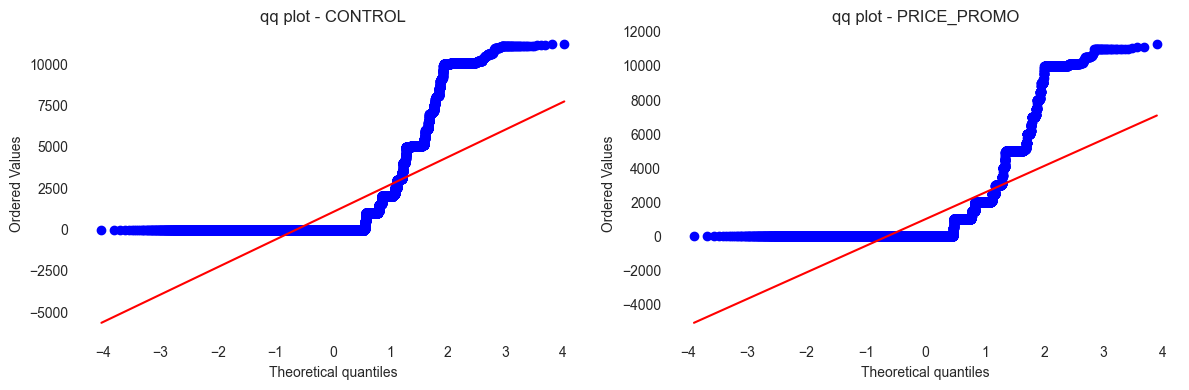

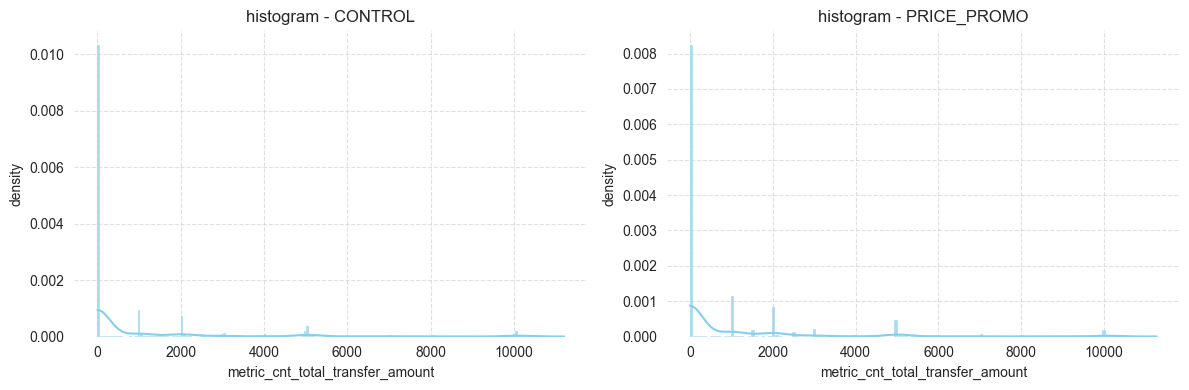

/var/folders/hv/ckh3m6gn1sd45q2qctrqcwzh0000gn/T/ipykernel_32414/1546499067.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


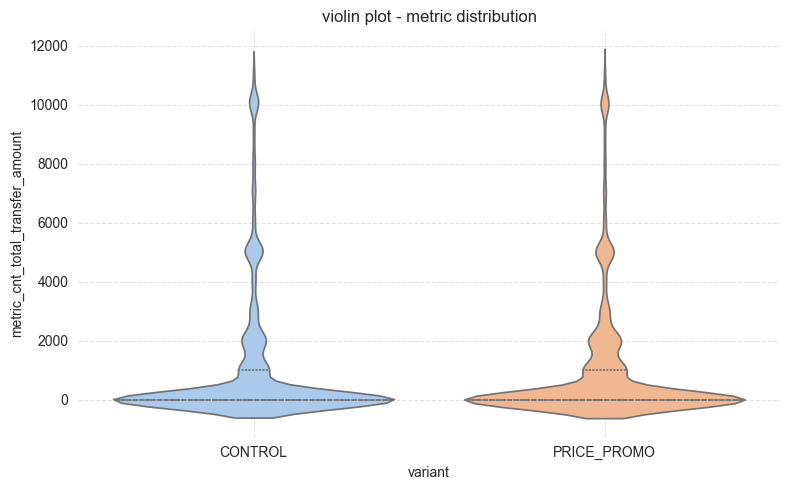

/var/folders/hv/ckh3m6gn1sd45q2qctrqcwzh0000gn/T/ipykernel_32414/1546499067.py:90: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/var/folders/hv/ckh3m6gn1sd45q2qctrqcwzh0000gn/T/ipykernel_32414/1546499067.py:90: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


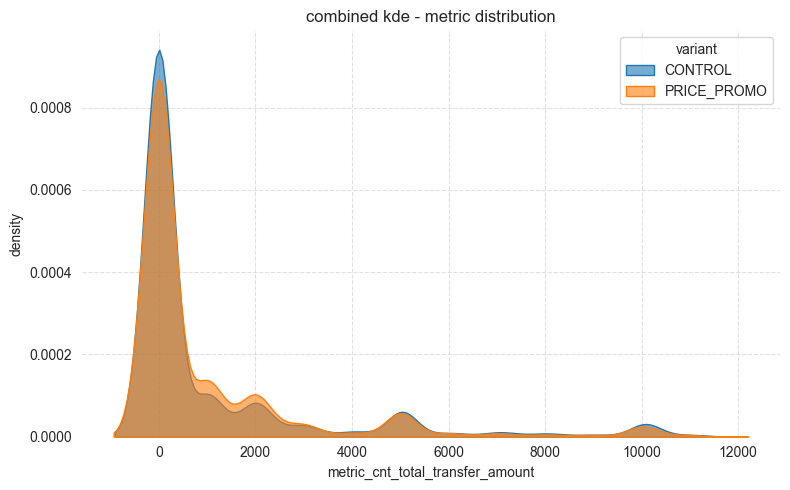

variant CONTROL: normaltest statistic = 12825.5424, p-value = 0.0000
variant PRICE_PROMO: normaltest statistic = 7987.9361, p-value = 0.0000


In [160]:
plot_qq(selected_df, variant_column, metric_column)
plot_histogram_kde(selected_df, variant_column, metric_column)
plot_violin(selected_df, variant_column, metric_column)
plot_combined_kde(selected_df, variant_column, metric_column)

results = calculate_distribution(selected_df, variant_column, metric_column)

### SAMPLE VARIANCES

In [ ]:
# check if the variances are similar between variantes
# add boxplot

## STATISTICAL TESTING

### TEST AND TECHNICHES SELECTION

In [17]:
## Two variants tests
use_mann_whitney_u_test = False # continuous, not normal, works with unbalanced samples
use_welchs_t_test = False # continuous, normal, different variances, works with unbalanced samples (if low unbalance applied although same variants)
use_t_test = False # continuous, normal, equal variances, not recommended if unbalanced
use_z_test = False # continuous data, large sample size, known population real variance, not recommended if unbalanced, not used because you never know the real variance
use_fisher_exact_test = False # proportions, small sample size, works with unbalanced samples, # for proportions, only size matters due to central limit theorem
use_two_proportion_z_test = False # proportions, large sample size, works with unbalanced samples, used alone or post Pearson Chi-square with Bonferroni for multiple variants, # for proportions, only size matters due to central limit theorem

## Multiple variants tests
use_anova_test = False # continuous, normal, not recommended if unbalanced
use_welch_anova_test = False # continuous, normal, if unbalanced
use_pearson_chi_square_test = False # proportions, works with unbalanced samples but needs correction
use_kruskal_wallis_test = False # continuous, not normal, works with unbalanced samples

## Multiple variants post-pairs tests
use_tukey_hsd_test = False # post anova, continuous, not recommended if unbalanced
use_games_howell_test = False # post anova, continuous, for unbalanced samples
use_dunn_test = False # post kruskal wallis, continuous, needs bonferroni, works with unbalanced samples

## Multiple variants correction
use_bonferroni_correction = False # if more than 2 variants and tukey pr games howell is not used

## Unbalance data: N = A/B, if N < 2.5 use normal testing, if N < 5x use balance resampling, if N > 5x use bootstraping
use_balance_resampling = False # for unbalanced sample sizes, equalizing groups, downsampling,
use_bootstraping = False # for small sample sizes or unbalanced groups, estimating confidence intervals, upsampling,

## Additional techniques
use_bayesian_test = False # for probabilistic interpretation, alternative to p-values, small samples
use_permutation_test = False # for distribution-free significance testing, alternative to t-tests or z-tests, extrange distributions

In [20]:
## Segmentation
use_welchs_t_test_segmentation = False # for comparing two segments (A-New vs. B-New), continuous, normal, can unbalanced
use_mann_whitney_u_test_segmentation = False # for comparing two segments (A-New vs. B-New), continuous, not normal, can unbalanced
use_two_proportion_z_test_segmentation = False # for comparing two segments (A-New vs. B-New), proportions, large sample
use_fisher_exact_test_segmentation = False # for comparing two segments (A-New vs. B-New), proportions, small sample

## Interaction Tests, if discrepancies between segments
use_anova_interaction_test_segmentation = False # to test interaction effect between variant and segment, continuous, normal
use_welch_anova_interaction_test_segmentation = False # to test interaction effect between variant and segment, continuous, normal, can unbalanced
use_kruskal_wallis_interaction_test_segmentation = False # to test interaction effect between variant and segment, continuous, not normal
use_logistic_regression_interaction_test_segmentation = False # to test interaction effect for proportions, equivalent to ANOVA for categorical data
# if true, post hoc with tukey, games howell or dunn

### UNBALANCE DATA

#### BALANCE RESAMPLING

#### BOOTSTRAPING

### ADDITIONAL TECHNIQUES

#### BAYESIAN TEST

#### PERMUTATION TEST

## SEGMENT ANALYSIS